In [17]:
# 使用 floweaver 和 holoviews 创建四列连续桑基图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import matplotlib

# 设置全局字体为Arial
plt.rcParams.update({
    'font.family': 'Arial',  # 设置字体为Arial
    'font.size': 16,  # 基础字体大小
})

# =============================================================================
# 数据预处理部分 - 三个情景的四列桑基图数据准备
# =============================================================================

# 1. 读取岛屿可行性分析数据
data_path = Path("../result/island_viability_summary_electric.csv")
df = pd.read_csv(data_path)  # 加载原始数据
print(f"原始数据形状: {df.shape}")  # 显示数据维度信息

# 2. 加载IPCC区域地理数据用于区域分配
try:
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")  # 加载IPCC区域边界数据
    ipcc_regions.sindex  # 创建空间索引以加速地理查询
    print("IPCC区域地理数据加载成功")
except Exception as e:
    print(f"无法加载IPCC区域数据: {e}")
    ipcc_regions = None

# 3. 定义IPCC区域分配函数（高效版本）
def assign_ipcc_region_optimized(lat, lon, ipcc_regions_gdf):
    """使用空间索引高效地将坐标分配到IPCC区域"""
    point = Point(lon, lat)  # 创建点几何对象
    possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))  # 空间索引快速筛选
    possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]  # 获取可能匹配的区域
    precise_matches = possible_matches[possible_matches.contains(point)]  # 精确几何匹配
    if not precise_matches.empty:
        return precise_matches.iloc[0]['Acronym']  # 返回区域简称
    return 'Unknown'  # 未匹配到区域时返回Unknown

# 4. 定义变化计算函数（与上面cell保持一致）
def calculate_position_change(df_base, df_compare):
    """计算两个情景之间的位置变化 - 修正版，包含IPCC区域信息"""
    # 修正：合并时包含ipcc_region信息
    merged = pd.merge(df_base[['island_id', 'tariff_breakeven', 'ipcc_region']],
                      df_compare[['island_id', 'tariff_breakeven']],
                      on='island_id', suffixes=('_base', '_compare'))
    merged['position_change'] = abs(merged['tariff_breakeven_compare'] - merged['tariff_breakeven_base'])
    # 重命名ipcc_region列以保持一致性
    merged = merged.rename(columns={'ipcc_region': 'ipcc_region_base'})
    return merged

# 5. 为整个数据集分配IPCC区域（与上面cell保持一致）
if ipcc_regions is not None:
    print("正在为岛屿分配IPCC区域...")
    df['ipcc_region'] = df.apply(
        lambda row: assign_ipcc_region_optimized(row['lat'], row['lon'], ipcc_regions), axis=1
    )  # 应用区域分配函数
    print(f"区域分配完成，涉及区域: {df['ipcc_region'].nunique()}")
else:
    df['ipcc_region'] = 'Unknown'  # 如果没有区域数据，设为Unknown

# =============================================================================
# NEW: 先筛选在2020年scenario有显著变化的岛屿
# =============================================================================

# print("\n=== 筛选在2020年scenario有显著变化的岛屿 ===")

# # 获取Ideal和2020年scenario的数据
# df_ideal = df[df['scenario'] == 'output_0'].copy()  # Ideal情景数据
# df_2020 = df[df['scenario'] == 'output_2020'].copy()  # 2020年情景数据

# # 计算变化
# change_data = calculate_position_change(df_ideal, df_2020)
# significant_threshold = 0.05  # 显著变化阈值
# significant_changes = change_data[change_data['position_change'] > significant_threshold]

# print(f"原始岛屿总数: {len(df_ideal)}")
# print(f"在2020年scenario有显著变化的岛屿数: {len(significant_changes)}")
# print(f"显著变化阈值: {significant_threshold}")

# # 获取有显著变化的岛屿ID列表
# significant_island_ids = significant_changes['island_id'].unique()
# print(f"有显著变化的唯一岛屿数: {len(significant_island_ids)}")

# # 从原始数据中筛选出这些有显著变化的岛屿
# df_filtered = df[df['island_id'].isin(significant_island_ids)].copy()
# print(f"筛选后的数据形状: {df_filtered.shape}")
df_filtered = df
# =============================================================================
# 6. 在有显著变化的岛屿中，再筛选有效区域（岛屿数量阈值）
# =============================================================================

print("\n=== 在有显著变化的岛屿中应用区域数量阈值 ===")

MIN_ISLANDS_PER_REGION = 10  # 每个区域最少岛屿数量阈值

# 统计有显著变化的岛屿在各区域的分布
region_counts_filtered = df_filtered['ipcc_region'].value_counts()  # 统计各区域岛屿数量
valid_regions = region_counts_filtered[region_counts_filtered > MIN_ISLANDS_PER_REGION].index.tolist()  # 筛选有效区域

print(f"有显著变化岛屿的区域分布:")
print(region_counts_filtered.head(10))
print(f"满足数量阈值的有效区域 (岛屿数量>{MIN_ISLANDS_PER_REGION}): {len(valid_regions)} 个")
print(f"有效区域列表: {valid_regions}")

# 最终筛选：既有显著变化又在有效区域的岛屿
df_final = df_filtered[df_filtered['ipcc_region'].isin(valid_regions)].copy()
final_island_ids = df_final['island_id'].unique()

print(f"最终用于桑基图的岛屿数: {len(final_island_ids)}")
print(f"最终数据形状: {df_final.shape}")

# =============================================================================
# 7. 定义象限分类函数
# =============================================================================

def classify_quadrant(row, median_breakeven, median_affordable):
    """根据电价中位数将岛屿分类到四个象限"""
    breakeven = row['tariff_breakeven']  # 盈亏平衡电价
    affordable = row['tariff_affordable']  # 可负担电价

    if affordable > median_affordable and breakeven <= median_breakeven:
        return 'High Affordable\\nLow Cost'  # 高可负担性、低成本
    elif affordable > median_affordable and breakeven > median_breakeven:
        return 'High Affordable\\nHigh Cost'  # 高可负担性、高成本
    elif affordable <= median_affordable and breakeven <= median_breakeven:
        return 'Low Affordable\\nLow Cost'  # 低可负担性、低成本
    else:
        return 'Low Affordable\\nHigh Cost'  # 低可负担性、高成本

# =============================================================================
# 8. 处理三个情景的数据并计算统一的中位数分类基准（修正版）
# =============================================================================

scenarios = ['output_0', 'output_2020', 'output_2050']  # 三个主要情景
scenario_labels = ['Ideal', 'Baseline', 'Climate Stress']  # 情景标签

# 准备合并数据的列表
combined_data = []

# 首先从output_0（Ideal情景）计算全局中位数基准
df_output_0 = df_final[df_final['scenario'] == 'output_0'].copy()  # 获取Ideal情景数据
global_median_breakeven = df_output_0['tariff_breakeven'].median()  # 全局盈亏平衡电价中位数
global_median_affordable = df_output_0['tariff_affordable'].median()  # 全局可负担电价中位数

print(f"=== 使用统一的output_0中位数基准进行所有情景的分类 ===")
print(f"全局基准 - 盈亏平衡电价中位数: {global_median_breakeven:.3f}")
print(f"全局基准 - 可负担电价中位数: {global_median_affordable:.3f}")

# 为每个情景使用统一的全局中位数进行分类（只针对最终筛选的岛屿）
for scenario in scenarios:
    df_scenario = df_final[df_final['scenario'] == scenario].copy()  # 筛选情景数据

    # 使用统一的全局中位数基准进行象限分类
    df_scenario['quadrant'] = df_scenario.apply(
        lambda row: classify_quadrant(row, global_median_breakeven, global_median_affordable), axis=1
    )  # 为每个岛屿分配象限，使用统一基准

    print(f"情景 {scenario}: 有效岛屿数 {len(df_scenario)}, 使用统一基准分类")

    combined_data.append(df_scenario)

# =============================================================================
# 9. 创建四列桑基图的数据结构
# =============================================================================

def prepare_four_column_sankey_data(df_list):
    """为四列桑基图准备数据"""

    # 找到所有情景中共同存在的岛屿
    common_islands = set(df_list[0]['island_id'])
    for df_scenario in df_list[1:]:
        common_islands = common_islands.intersection(set(df_scenario['island_id']))

    print(f"三个情景共同存在的岛屿数量: {len(common_islands)}")

    # 为共同岛屿创建桑基图数据
    sankey_data = []

    for island_id in common_islands:
        # 获取该岛屿在三个情景下的信息
        island_info = {}
        for i, df_scenario in enumerate(df_list):
            island_row = df_scenario[df_scenario['island_id'] == island_id].iloc[0]
            island_info[f'scenario_{i}'] = {
                'region': island_row['ipcc_region'],
                'quadrant': island_row['quadrant']
            }

        # 添加到桑基图数据
        sankey_data.append({
            'island_id': island_id,
            'region': island_info['scenario_0']['region'],  # 第一列：区域
            'ideal_class': island_info['scenario_0']['quadrant'],  # 第二列：Ideal分类
            'baseline_class': island_info['scenario_1']['quadrant'],  # 第三列：Baseline分类
            'climate_class': island_info['scenario_2']['quadrant']  # 第四列：Climate Stress分类
        })

    return pd.DataFrame(sankey_data)

# =============================================================================
# 10. 准备桑基图数据
# =============================================================================

sankey_df = prepare_four_column_sankey_data(combined_data)
print(f"\n=== 最终桑基图数据摘要 ===")
print(f"桑基图数据准备完成，包含 {len(sankey_df)} 个岛屿")
print(f"涉及区域: {sankey_df['region'].nunique()} 个")
print(f"区域列表: {sorted(sankey_df['region'].unique())}")

# 打印筛选过程摘要
print(f"\n=== 筛选过程摘要 ===")
# print(f"1. 原始岛屿总数: {len(df_ideal)}")
# print(f"2. 在2020年有显著变化的岛屿: {len(significant_island_ids)}")
print(f"3. 满足区域数量阈值的岛屿: {len(final_island_ids)}")
print(f"4. 最终桑基图岛屿数: {len(sankey_df)}")
print(f"5. 最终涉及区域数: {len(valid_regions)}")

# --- 可选：将数据保存为 CSV 文件，供 R 使用 ---
output_path = "sankey_data_for_r.csv"
sankey_df.to_csv(output_path, index=False)
print(f"数据已成功导出到: {output_path}")

原始数据形状: (10980, 16)
IPCC区域地理数据加载成功
正在为岛屿分配IPCC区域...
区域分配完成，涉及区域: 43

=== 在有显著变化的岛屿中应用区域数量阈值 ===
有显著变化岛屿的区域分布:
ipcc_region
SEA    4188
EAS    1002
NEU     924
MED     690
EPO     528
SAS     528
SPO     504
CAR     366
ENA     270
WAF     192
Name: count, dtype: int64
满足数量阈值的有效区域 (岛屿数量>10): 39 个
有效区域列表: ['SEA', 'EAS', 'NEU', 'MED', 'EPO', 'SAS', 'SPO', 'CAR', 'ENA', 'WAF', 'NAU', 'NAO', 'SWS', 'NWN', 'WNA', 'ARP', 'SCA', 'NPO', 'NZ', 'BOB', 'SSA', 'RFE', 'MDG', 'NCA', 'SAH', 'SAU', 'WCA', 'WCE', 'SEAF', 'NEN', 'ESAF', 'EIO', 'NES', 'EAU', 'SIO', 'GIC', 'CAF', 'EAO', 'NSA']
最终用于桑基图的岛屿数: 1825
最终数据形状: (10956, 17)
=== 使用统一的output_0中位数基准进行所有情景的分类 ===
全局基准 - 盈亏平衡电价中位数: 0.197
全局基准 - 可负担电价中位数: 0.146
情景 output_0: 有效岛屿数 1826, 使用统一基准分类
情景 output_2020: 有效岛屿数 1826, 使用统一基准分类
情景 output_2050: 有效岛屿数 1826, 使用统一基准分类
三个情景共同存在的岛屿数量: 1825

=== 最终桑基图数据摘要 ===
桑基图数据准备完成，包含 1825 个岛屿
涉及区域: 39 个
区域列表: ['ARP', 'BOB', 'CAF', 'CAR', 'EAO', 'EAS', 'EAU', 'EIO', 'ENA', 'EPO', 'ESAF', 'GIC', 'MDG', 'MED', 'NAO', 'NAU', 

In [18]:
sankey_df

,island_id,region,ideal_class,baseline_class,climate_class
0,65545,SEA,Low Affordable\nLow Cost,Low Affordable\nLow Cost,Low Affordable\nLow Cost
1,49163,NEU,High Affordable\nHigh Cost,High Affordable\nHigh Cost,High Affordable\nHigh Cost
2,40971,NEU,High Affordable\nHigh Cost,High Affordable\nHigh Cost,High Affordable\nHigh Cost
3,73748,SEA,High Affordable\nHigh Cost,High Affordable\nHigh Cost,High Affordable\nHigh Cost
4,65558,SEA,Low Affordable\nLow Cost,Low Affordable\nLow Cost,Low Affordable\nLow Cost
...,...,...,...,...,...
1820,40937,NEU,High Affordable\nHigh Cost,High Affordable\nHigh Cost,High Affordable\nHigh Cost
1821,40939,NEU,High Affordable\nHigh Cost,High Affordable\nHigh Cost,High Affordable\nHigh Cost
1822,73708,SEA,Low Affordable\nLow Cost,Low Affordable\nHigh Cost,Low Affordable\nHigh Cost
1823,65517,SEA,Low Affordable\nLow Cost,Low Affordable\nLow Cost,Low Affordable\nLow Cost


In [19]:
# 1. 识别发生过分类变化的岛屿
changed_island_ids = []
for _, row in sankey_df.iterrows():
    # 如果三个情景的分类不完全相同，就认为发生了变化
    if not (row['ideal_class'] == row['baseline_class'] == row['climate_class']):
        changed_island_ids.append(row['island_id'])

print(f"发生过分类变化的岛屿数量: {len(changed_island_ids)}")

# 2. 获取这些变化岛屿所在的区域
changed_regions = sankey_df[sankey_df['island_id'].isin(changed_island_ids)]['region'].unique()
print(f"有岛屿发生变化的区域: {sorted(changed_regions)}")

# 3. 在有岛屿发生变化的区域中，筛选岛屿数量大于10个的区域
MIN_ISLANDS_PER_REGION = 10  # 每个区域最少岛屿数量阈值
region_counts_in_changed = sankey_df[sankey_df['region'].isin(changed_regions)]['region'].value_counts()
valid_changed_regions = region_counts_in_changed[region_counts_in_changed >= MIN_ISLANDS_PER_REGION].index.tolist()

print(f"有变化区域的岛屿数量分布:")
for region in sorted(changed_regions):
    count = region_counts_in_changed.get(region, 0)
    status = "✓" if count > MIN_ISLANDS_PER_REGION else "✗"
    print(f"  {region}: {count} 个岛屿 {status}")

print(f"满足数量阈值(>{MIN_ISLANDS_PER_REGION})的有效变化区域: {len(valid_changed_regions)} 个")
print(f"有效区域列表: {sorted(valid_changed_regions)}")

# 4. 筛选出这些有效区域内的所有岛屿（包括未变化的）
sankey_df_filtered = sankey_df[sankey_df['region'].isin(valid_changed_regions)].copy()

print(f"原始数据: {len(sankey_df)} 个岛屿")
print(f"筛选后数据: {len(sankey_df_filtered)} 个岛屿")

# 现在sankey_df_filtered就是你要的结果
sankey_df_filtered

发生过分类变化的岛屿数量: 126
有岛屿发生变化的区域: ['BOB', 'EAS', 'MDG', 'MED', 'NPO', 'NZ', 'SAS', 'SAU', 'SCA', 'SEA', 'SIO', 'SPO', 'SWS', 'WCE']
有变化区域的岛屿数量分布:
  BOB: 11 个岛屿 ✓
  EAS: 167 个岛屿 ✓
  MDG: 10 个岛屿 ✗
  MED: 115 个岛屿 ✓
  NPO: 13 个岛屿 ✓
  NZ: 11 个岛屿 ✓
  SAS: 88 个岛屿 ✓
  SAU: 8 个岛屿 ✗
  SCA: 13 个岛屿 ✓
  SEA: 698 个岛屿 ✓
  SIO: 3 个岛屿 ✗
  SPO: 84 个岛屿 ✓
  SWS: 26 个岛屿 ✓
  WCE: 6 个岛屿 ✗
满足数量阈值(>10)的有效变化区域: 11 个
有效区域列表: ['BOB', 'EAS', 'MDG', 'MED', 'NPO', 'NZ', 'SAS', 'SCA', 'SEA', 'SPO', 'SWS']
原始数据: 1825 个岛屿
筛选后数据: 1236 个岛屿


,island_id,region,ideal_class,baseline_class,climate_class
0,65545,SEA,Low Affordable\nLow Cost,Low Affordable\nLow Cost,Low Affordable\nLow Cost
3,73748,SEA,High Affordable\nHigh Cost,High Affordable\nHigh Cost,High Affordable\nHigh Cost
4,65558,SEA,Low Affordable\nLow Cost,Low Affordable\nLow Cost,Low Affordable\nLow Cost
7,73776,SEA,Low Affordable\nHigh Cost,Low Affordable\nHigh Cost,Low Affordable\nHigh Cost
9,73787,SEA,Low Affordable\nHigh Cost,Low Affordable\nHigh Cost,Low Affordable\nHigh Cost
...,...,...,...,...,...
1818,65511,SEA,Low Affordable\nLow Cost,Low Affordable\nLow Cost,Low Affordable\nLow Cost
1819,73704,SEA,Low Affordable\nLow Cost,Low Affordable\nLow Cost,Low Affordable\nLow Cost
1822,73708,SEA,Low Affordable\nLow Cost,Low Affordable\nHigh Cost,Low Affordable\nHigh Cost
1823,65517,SEA,Low Affordable\nLow Cost,Low Affordable\nLow Cost,Low Affordable\nLow Cost


In [20]:
sankey_df_filtered.to_csv('chongji_for_R.csv', index=False)

In [21]:
# 只保留实际发生分类变化的岛屿，而不是整个区域
# 这样桑基图会更精准地反映真正发生变化的情况

# 1. 识别发生过分类变化的岛屿
changed_island_ids = []
for _, row in sankey_df_filtered.iterrows():
    # 如果三个情景的分类不完全相同，就认为发生了变化
    if not (row['ideal_class'] == row['baseline_class'] == row['climate_class']):
        changed_island_ids.append(row['island_id'])

print(f"在有效区域中，实际发生分类变化的岛屿数量: {len(changed_island_ids)}")

# 2. 只保留发生变化的岛屿
sankey_df = sankey_df_filtered[sankey_df_filtered['island_id'].isin(changed_island_ids)].copy()

print(f"筛选前（有效区域所有岛屿）: {len(sankey_df_filtered)} 个岛屿")
print(f"筛选后（仅变化岛屿）: {len(sankey_df)} 个岛屿")
print(f"涉及区域数: {sankey_df['region'].nunique()} 个")

# 3. 检查每个区域的变化岛屿分布
region_change_counts = sankey_df['region'].value_counts()
print(f"\n各区域的变化岛屿分布:")
for region in sorted(region_change_counts.index):
    count = region_change_counts[region]
    print(f"  {region}: {count} 个变化岛屿")

print(f"\n=== 桑基图将只显示实际发生分类变化的 {len(sankey_df)} 个岛屿 ===")

在有效区域中，实际发生分类变化的岛屿数量: 116
筛选前（有效区域所有岛屿）: 1236 个岛屿
筛选后（仅变化岛屿）: 116 个岛屿
涉及区域数: 11 个

各区域的变化岛屿分布:
  BOB: 1 个变化岛屿
  EAS: 42 个变化岛屿
  MDG: 1 个变化岛屿
  MED: 5 个变化岛屿
  NPO: 3 个变化岛屿
  NZ: 4 个变化岛屿
  SAS: 1 个变化岛屿
  SCA: 1 个变化岛屿
  SEA: 50 个变化岛屿
  SPO: 1 个变化岛屿
  SWS: 7 个变化岛屿

=== 桑基图将只显示实际发生分类变化的 116 个岛屿 ===


In [22]:
sankey_df.to_csv('chongji_for_R_2.csv', index=False)

开始创建Nature Communications风格四层桑基图（使用统一的四象限颜色）...
桑基图数据检查通过，包含 116 个岛屿
涉及区域: 11 个
涉及分类组合: 8 种
使用与其他图表一致的四象限颜色配色方案
为 11 个区域生成了高对比度的区分色彩
创建了 23 个节点（所有标签已注释）
开始构建链接关系...
第1层到第2层链接: 15 条
第2层到第3层链接: 17 条
第3层到第4层链接: 19 条
总链接数: 51

                                    桑基图颜色图例                                     

🎨 四象限分类颜色（节点颜色）:
------------------------------------------------------------
 1. High Affordable
      Low Cost
     颜色代码: #2E8B57
     描述: 最理想状态

 2. High Affordable
      High Cost
     颜色代码: #4682B4
     描述: 高成本但可负担

 3. Low Affordable
      Low Cost
     颜色代码: #FF8C00
     描述: 成本低但可负担性差

 4. Low Affordable
      High Cost
     颜色代码: #DC143C
     描述: 最不理想状态

🌍 IPCC区域颜色（流向颜色）:
------------------------------------------------------------
 1. BOB (包含 1 个变化岛屿)
     颜色代码: #012A61

 2. EAS (包含 42 个变化岛屿)
     颜色代码: #015696

 3. MDG (包含 1 个变化岛屿)
     颜色代码: #0B75B3

 4. MED (包含 5 个变化岛屿)
     颜色代码: #4596CD

 5. NPO (包含 3 个变化岛屿)
     颜色代码: #89CAEA

 6. NZ (包含 4 个变化岛屿)
     颜色代码: #BBE6FA

 7. S

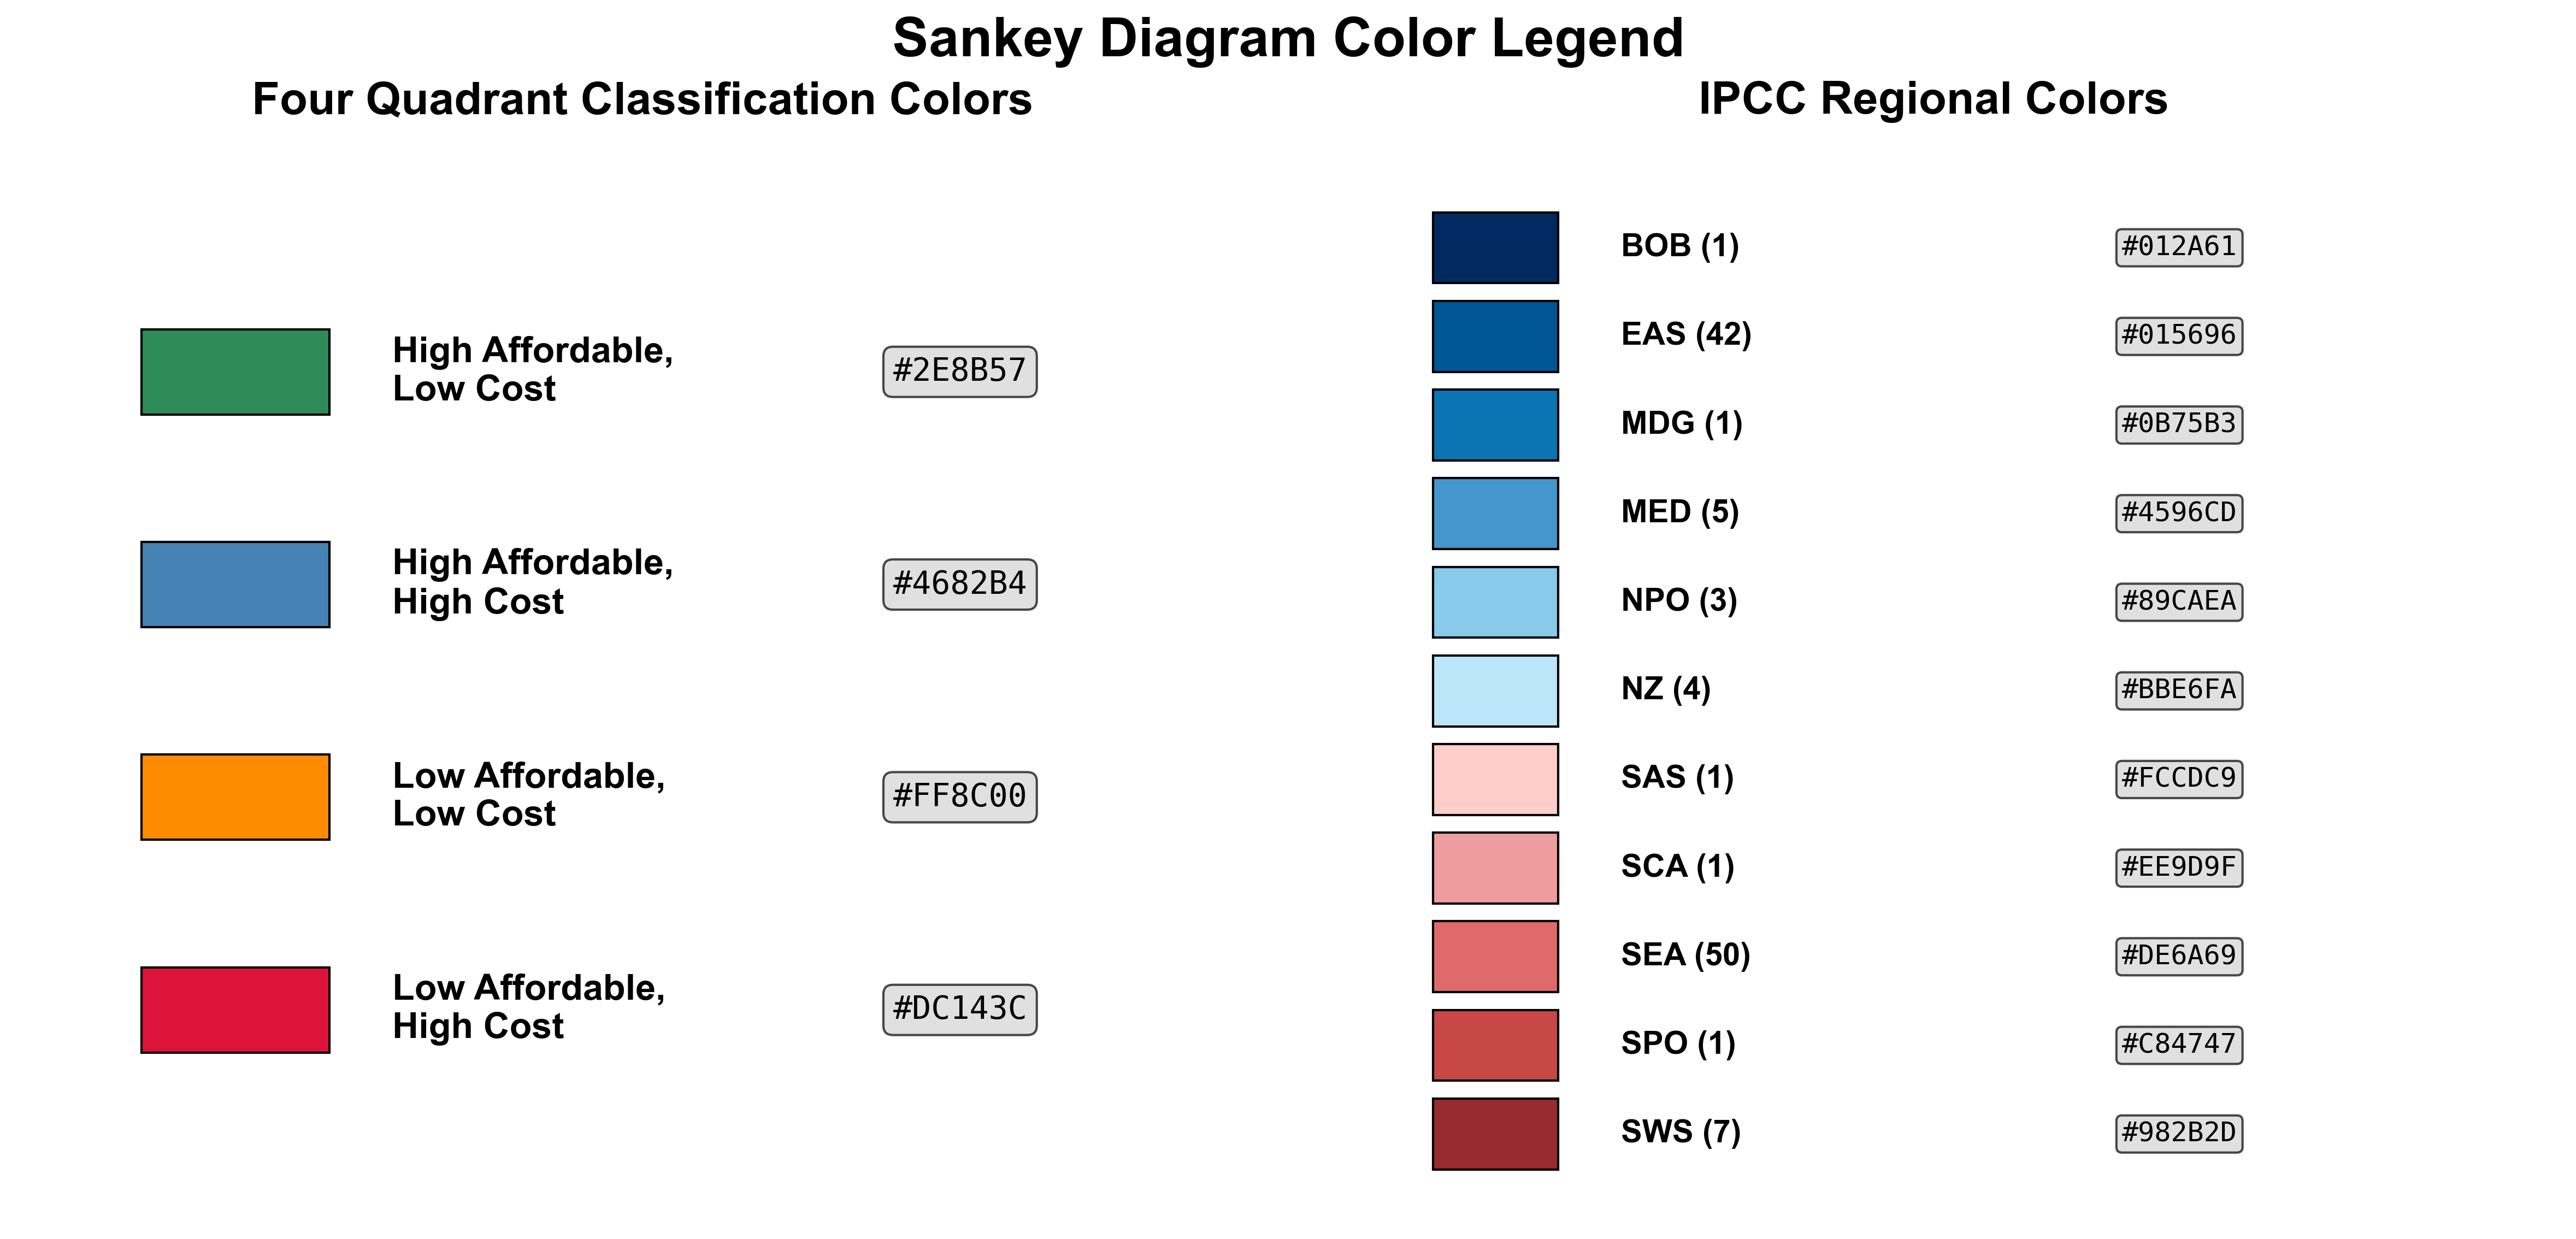


=== 无标签版本桑基图样式摘要 ===
✓ 四象限分类颜色（与其他图表一致）:
   High Affordable, Low Cost: #2E8B57
   High Affordable, High Cost: #4682B4
   Low Affordable, Low Cost: #FF8C00
   Low Affordable, High Cost: #DC143C
✓ 区域颜色: 11 种高对比度色彩，避免与分类颜色冲突
✓ 链接透明度: 0.5，保持区域颜色连续性
✓ Nature期刊风格: Arial字体，简洁布局
✓ 所有节点标签已注释，呈现纯色彩流动效果
✓ 详细颜色图例已生成，包含所有颜色映射关系

数据统计:
总岛屿数: 116
涉及区域数: 11
总节点数: 23
总链接数: 51

=== Nature风格桑基图及图例完成 ===
✓ 与fig4.4.ipynb和fig4.1.ipynb使用相同的四象限颜色
✓ 区域使用高对比度色彩，避免视觉混淆
✓ 纯色彩流动，更加简洁优雅
✓ 期刊级别的图形质量
✓ 完整的颜色图例，便于理解各颜色含义


In [23]:
# 9. --- Nature Communications风格四层桑基图：Region -> Ideal -> Baseline -> Climate Stress ---

import plotly.graph_objects as go  # 导入plotly桑基图绘制库
import plotly.io as pio  # 导入plotly IO库用于格式设置
import matplotlib.cm as cm  # matplotlib颜色映射库
import matplotlib.colors as mcolors  # matplotlib颜色工具
import numpy as np  # 数值计算库

print("开始创建Nature Communications风格四层桑基图（使用统一的四象限颜色）...")

# 设置plotly默认样式为静态图，符合期刊要求
pio.renderers.default = "browser"  # 设置输出渲染器为浏览器

# =============================================================================
# 1. 数据检查和预处理
# =============================================================================

# 检查桑基图数据是否存在
if 'sankey_df' not in locals():
    print("错误：sankey_df数据不存在，请先运行上一个cell生成数据")
else:
    print(f"桑基图数据检查通过，包含 {len(sankey_df)} 个岛屿")
    print(f"涉及区域: {sankey_df['region'].nunique()} 个")
    print(f"涉及分类组合: {len(sankey_df[['ideal_class', 'baseline_class', 'climate_class']].drop_duplicates())} 种")

# =============================================================================
# 2. Nature风格颜色映射 - 使用统一的四象限分类颜色
# =============================================================================

# 定义四个主要类别的颜色 - 与fig4.4.ipynb和fig4.1.ipynb保持一致
quadrant_colors_hex = {
    'High Affordable, Low Cost': '#2E8B57',      # 森林绿 - 最理想状态
    'High Affordable, High Cost': '#4682B4',     # 钢蓝色 - 可负担但成本高
    'Low Affordable, Low Cost': '#FF8C00',       # 橙色 - 可负担性低但成本低
    'Low Affordable, High Cost': '#DC143C'       # 深红色 - 最不理想状态
}

# 转换为Plotly需要的rgba格式，并调整透明度
def hex_to_rgba(hex_color, alpha=0.85):
    """将十六进制颜色转换为rgba格式"""
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16) 
    b = int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {alpha})'

# 转换四象限颜色为rgba格式（注意这里使用的是\\n作为换行符）
category_colors = {
    'High Affordable\\nLow Cost': hex_to_rgba('#2E8B57', 1),      # 森林绿
    'High Affordable\\nHigh Cost': hex_to_rgba('#4682B4', 1),     # 钢蓝色
    'Low Affordable\\nLow Cost': hex_to_rgba('#FF8C00', 1),       # 橙色
    'Low Affordable\\nHigh Cost': hex_to_rgba('#DC143C', 1)       # 深红色
}

print(f"使用与其他图表一致的四象限颜色配色方案")

# 为区域生成高对比度的不同颜色 - 避免与分类颜色相似
def generate_distinct_region_colors(regions):
    """生成与四象限颜色高度区分的区域颜色"""
    
    # 使用完全不同于四象限颜色的颜色系列
    # 避免使用：森林绿(#2E8B57)、钢蓝色(#4682B4)、橙色(#FF8C00)、深红色(#DC143C)
    distinct_region_colors = [
        '#012A61',
        '#015696',
        '#0B75B3',
        '#4596CD',
        '#89CAEA',
        '#BBE6FA',
        '#FCCDC9',
        '#EE9D9F',
        '#DE6A69',
        '#C84747',
        '#982B2D'
    ]
    
    region_colors = {}
    region_colors_hex = {}  # 同时保存十六进制格式用于图例
    for i, region in enumerate(regions):
        # 循环使用不同的颜色，确保区域间有明显区别
        color_idx = i % len(distinct_region_colors)
        hex_color = distinct_region_colors[color_idx]
        region_colors[region] = hex_to_rgba(hex_color, 0.75)  # 稍微透明一些以区分层级
        region_colors_hex[region] = hex_color  # 保存十六进制格式
    
    return region_colors, region_colors_hex

# 获取所有唯一区域并生成颜色
unique_regions = sorted(sankey_df['region'].unique())
region_colors, region_colors_hex = generate_distinct_region_colors(unique_regions)

print(f"为 {len(unique_regions)} 个区域生成了高对比度的区分色彩")

# =============================================================================
# 3. 构建四层桑基图的节点和链接数据结构
# =============================================================================

# 定义四个层级的所有可能节点
all_regions = sorted(sankey_df['region'].unique())  # 第1层：区域
all_ideal_classes = sorted(sankey_df['ideal_class'].unique())  # 第2层：Ideal分类
all_baseline_classes = sorted(sankey_df['baseline_class'].unique())  # 第3层：Baseline分类
all_climate_classes = sorted(sankey_df['climate_class'].unique())  # 第4层：Climate Stress分类

# 创建节点标签列表（按层级顺序） - 注释掉所有标签
node_labels = []
node_colors = []  # 节点颜色列表

# 第1层：区域节点 - 注释掉标签
for region in all_regions:
    # node_labels.append(region)  # 注释掉区域标签
    node_labels.append("")  # 使用空标签
    node_colors.append(region_colors[region])  # 使用区域对应颜色

# 第2层：Ideal分类节点 - 使用类别颜色
for ideal_class in all_ideal_classes:
    node_labels.append("")  # 不显示中间节点标签
    node_colors.append(category_colors[ideal_class])  # 使用类别对应颜色

# 第3层：Baseline分类节点 - 使用类别颜色
for baseline_class in all_baseline_classes:
    node_labels.append("")  # 不显示中间节点标签
    node_colors.append(category_colors[baseline_class])

# 第4层：Climate Stress分类节点 - 注释掉最终标签
for climate_class in all_climate_classes:
    # # 简化标签显示
    # if climate_class == 'High Affordable\\nLow Cost':
    #     display_label = "High Affordable\nLow Cost"
    # elif climate_class == 'High Affordable\\nHigh Cost':
    #     display_label = "High Affordable\nHigh Cost"  
    # elif climate_class == 'Low Affordable\\nLow Cost':
    #     display_label = "Low Affordable\nLow Cost"
    # else:  # 'Low Affordable\\nHigh Cost'
    #     display_label = "Low Affordable\nHigh Cost"
    
    # node_labels.append(display_label)  # 注释掉分类标签
    node_labels.append("")  # 使用空标签
    node_colors.append(category_colors[climate_class])

print(f"创建了 {len(node_labels)} 个节点（所有标签已注释）")

# 创建节点索引映射字典
region_start_idx = 0
ideal_start_idx = len(all_regions)
baseline_start_idx = len(all_regions) + len(all_ideal_classes)
climate_start_idx = len(all_regions) + len(all_ideal_classes) + len(all_baseline_classes)

def get_node_index(layer, item):
    """获取节点索引"""
    if layer == 'region':
        return all_regions.index(item)
    elif layer == 'ideal':
        return ideal_start_idx + all_ideal_classes.index(item)
    elif layer == 'baseline':
        return baseline_start_idx + all_baseline_classes.index(item)
    else:  # climate
        return climate_start_idx + all_climate_classes.index(item)

# =============================================================================
# 4. 构建链接数据 - 保持region颜色的连续性
# =============================================================================

# 初始化链接列表
source_indices = []
target_indices = []
link_values = []
link_colors = []

print("开始构建链接关系...")

# --- 第1层到第2层的链接：Region -> Ideal ---
region_to_ideal = sankey_df.groupby(['region', 'ideal_class']).size().reset_index(name='count')
for _, row in region_to_ideal.iterrows():
    source_idx = get_node_index('region', row['region'])
    target_idx = get_node_index('ideal', row['ideal_class'])
    
    source_indices.append(source_idx)
    target_indices.append(target_idx)
    link_values.append(row['count'])
    # 使用稍微透明的区域颜色
    link_colors.append(region_colors[row['region']].replace('0.7)', '0.5)'))

print(f"第1层到第2层链接: {len(region_to_ideal)} 条")

# --- 第2层到第3层的链接：Ideal -> Baseline ---
ideal_to_baseline = sankey_df.groupby(['region', 'ideal_class', 'baseline_class']).size().reset_index(name='count')
for _, row in ideal_to_baseline.iterrows():
    source_idx = get_node_index('ideal', row['ideal_class'])
    target_idx = get_node_index('baseline', row['baseline_class'])
    
    source_indices.append(source_idx)
    target_indices.append(target_idx)
    link_values.append(row['count'])
    # 使用区域颜色保持连续性
    link_colors.append(region_colors[row['region']].replace('0.7)', '0.5)'))

print(f"第2层到第3层链接: {len(ideal_to_baseline)} 条")

# --- 第3层到第4层的链接：Baseline -> Climate Stress ---
baseline_to_climate = sankey_df.groupby(['region', 'baseline_class', 'climate_class']).size().reset_index(name='count')
for _, row in baseline_to_climate.iterrows():
    source_idx = get_node_index('baseline', row['baseline_class'])
    target_idx = get_node_index('climate', row['climate_class'])
    
    source_indices.append(source_idx)
    target_indices.append(target_idx)
    link_values.append(row['count'])
    # 使用区域颜色保持连续性
    link_colors.append(region_colors[row['region']].replace('0.7)', '0.5)'))

print(f"第3层到第4层链接: {len(baseline_to_climate)} 条")
print(f"总链接数: {len(source_indices)}")

# =============================================================================
# 5. 创建Nature风格的桑基图
# =============================================================================

# 创建桑基图对象
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,  # 节点间距
        thickness=25,  # 节点厚度
        line=dict(color="rgba(200, 200, 200, 0.5)", width=0.8),  # 淡边框
        label=node_labels,  # 所有标签都已注释为空字符串
        color=node_colors,
        # 四列布局
        x=[0.05 if i < len(all_regions) else
           0.35 if i < len(all_regions) + len(all_ideal_classes) else
           0.65 if i < len(all_regions) + len(all_ideal_classes) + len(all_baseline_classes) else
           0.95
           for i in range(len(node_labels))],
        y=[i/(max(len(all_regions)-1, 1)) if i < len(all_regions) else
           (i-len(all_regions))/(max(len(all_ideal_classes)-1, 1)) if i < len(all_regions) + len(all_ideal_classes) else
           (i-len(all_regions)-len(all_ideal_classes))/(max(len(all_baseline_classes)-1, 1)) if i < len(all_regions) + len(all_ideal_classes) + len(all_baseline_classes) else
           (i-len(all_regions)-len(all_ideal_classes)-len(all_baseline_classes))/(max(len(all_climate_classes)-1, 1))
           for i in range(len(node_labels))]
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=link_values,
        color=link_colors,
        line=dict(color="rgba(255, 255, 255, 0.3)", width=0.3)  # 淡链接边框
    )
)])

# =============================================================================
# 6. 应用Nature期刊样式设置
# =============================================================================

fig.update_layout(
    font=dict(
        family="Arial",  # Nature期刊标准字体
        size=18,         # 字体大小
        color="rgb(60, 60, 60)"  # 深灰色文字
    ),
    plot_bgcolor='rgb(255, 255, 255)',    # 纯白背景
    paper_bgcolor='rgb(255, 255, 255)',   # 纯白纸张背景
    width=1200,              # 图形宽度
    height=800,              # 图形高度
    margin=dict(
        l=50,   # 左边距
        r=150,  # 右边距，为标签留空间
        t=30,   # 上边距
        b=30    # 下边距
    ),
    showlegend=False  # 不显示图例
)

# 显示桑基图
fig.show()

# =============================================================================
# 7. 创建详细的颜色图例
# =============================================================================

print(f"\n" + "="*80)
print(f"{'桑基图颜色图例':^80}")
print(f"="*80)

# 打印四象限分类颜色图例
print(f"\n🎨 四象限分类颜色（节点颜色）:")
print(f"-" * 60)
for i, (category, hex_color) in enumerate(quadrant_colors_hex.items(), 1):
    # 将分类名称转换为更易读的格式
    display_name = category.replace(', ', '\n      ')  # 换行显示
    print(f"{i:2d}. {display_name}")
    print(f"     颜色代码: {hex_color}")
    print(f"     描述: {'最理想状态' if 'Low Cost' in category and 'High Affordable' in category else '高成本但可负担' if 'High Cost' in category and 'High Affordable' in category else '成本低但可负担性差' if 'Low Cost' in category and 'Low Affordable' in category else '最不理想状态'}")
    print()

# 打印区域颜色图例
print(f"🌍 IPCC区域颜色（流向颜色）:")
print(f"-" * 60)
# 获取该桑基图中实际出现的区域及其岛屿数量
region_island_counts = sankey_df['region'].value_counts().sort_index()

for i, region in enumerate(sorted(unique_regions), 1):
    island_count = region_island_counts.get(region, 0)
    hex_color = region_colors_hex[region]
    print(f"{i:2d}. {region} (包含 {island_count} 个变化岛屿)")
    print(f"     颜色代码: {hex_color}")
    print()

# 打印图例说明
print(f"📋 图例说明:")
print(f"-" * 60)
print(f"• 节点颜色: 代表四象限分类，基于统一的output_0中位数基准")
print(f"• 流向颜色: 代表IPCC区域，追踪岛屿从各区域的流动路径")
print(f"• 桑基图层级: 区域 → Ideal情景 → Baseline情景 → Climate Stress情景")
print(f"• 数据范围: 仅显示在三个情景间发生分类变化的 {len(sankey_df)} 个岛屿")
print(f"• 涉及区域: {len(unique_regions)} 个IPCC区域")

# =============================================================================
# 8. 使用matplotlib创建正式的图例图表
# =============================================================================

# 创建正式的matplotlib图例
import matplotlib.patches as patches

fig_legend, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), dpi=300)

# 左侧：四象限分类图例
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.set_title('Four Quadrant Classification Colors', fontsize=20, fontweight='bold', pad=20)

y_positions = [8, 6, 4, 2]
for i, (category, hex_color) in enumerate(quadrant_colors_hex.items()):
    # 绘制颜色方块
    rect = patches.Rectangle((1, y_positions[i]-0.4), 1.5, 0.8, 
                           linewidth=1, edgecolor='black', facecolor=hex_color)
    ax1.add_patch(rect)
    
    # 添加分类名称
    display_name = category.replace(', ', ',\n')
    ax1.text(3, y_positions[i], display_name, 
            fontsize=16, va='center', fontweight='bold')
    
    # 添加颜色代码
    ax1.text(7, y_positions[i], hex_color, 
            fontsize=14, va='center', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))

ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# 右侧：区域颜色图例
ax2.set_xlim(0, 10)
ax2.set_ylim(0, len(unique_regions) + 1)
ax2.set_title('IPCC Regional Colors', fontsize=20, fontweight='bold', pad=20)

for i, region in enumerate(unique_regions):
    y_pos = len(unique_regions) - i
    island_count = region_island_counts.get(region, 0)
    hex_color = region_colors_hex[region]
    
    # 绘制颜色方块
    rect = patches.Rectangle((1, y_pos-0.4), 1, 0.8, 
                           linewidth=1, edgecolor='black', facecolor=hex_color)
    ax2.add_patch(rect)
    
    # 添加区域名称和岛屿数量
    ax2.text(2.5, y_pos, f'{region} ({island_count})', 
            fontsize=14, va='center', fontweight='bold')
    
    # 添加颜色代码
    ax2.text(6.5, y_pos, hex_color, 
            fontsize=12, va='center', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='lightgray', alpha=0.7))

ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# 添加总体说明
fig_legend.suptitle('Sankey Diagram Color Legend', fontsize=24, fontweight='bold', y=0.95)

plt.tight_layout()
plt.show()

# =============================================================================
# 9. 打印最终摘要
# =============================================================================

print(f"\n=== 无标签版本桑基图样式摘要 ===")
print(f"✓ 四象限分类颜色（与其他图表一致）:")
for category, color in quadrant_colors_hex.items():
    print(f"   {category}: {color}")
print(f"✓ 区域颜色: {len(unique_regions)} 种高对比度色彩，避免与分类颜色冲突")
print(f"✓ 链接透明度: 0.5，保持区域颜色连续性")
print(f"✓ Nature期刊风格: Arial字体，简洁布局")
print(f"✓ 所有节点标签已注释，呈现纯色彩流动效果")
print(f"✓ 详细颜色图例已生成，包含所有颜色映射关系")

print(f"\n数据统计:")
print(f"总岛屿数: {len(sankey_df)}")
print(f"涉及区域数: {len(all_regions)}")
print(f"总节点数: {len(node_labels)}")
print(f"总链接数: {len(source_indices)}")

print(f"\n=== Nature风格桑基图及图例完成 ===")
print("✓ 与fig4.4.ipynb和fig4.1.ipynb使用相同的四象限颜色")
print("✓ 区域使用高对比度色彩，避免视觉混淆")
print("✓ 纯色彩流动，更加简洁优雅")
print("✓ 期刊级别的图形质量")
print("✓ 完整的颜色图例，便于理解各颜色含义")